# Matrix Factorization with Bias

Similar to 09_matrix_factorization.py, but with user and item bias (TODO: Add reference on why this bias is needed).

## Reference:
- https://github.com/GabrielSandoval/matrix_factorization/blob/master/lib/mf.py
- https://d2l.ai/chapter_recommender-systems/mf.html
- https://medium.com/@maxbrenner-ai/matrix-factorization-for-collaborative-filtering-linear-to-non-linear-models-in-python-5cf54363a03c
- https://github.com/NicolasHug/Surprise/blob/master/surprise/prediction_algorithms/matrix_factorization.pyx

Consider the following matrix of ratings. The rows are the users, while the columns are the items, and the values are the rating 1-5.
In the first row, we see that user rated 5 for the item.

The average rating for this matrix is 2.8 stars (after rounding).

In [1]:
import numpy as np

ratings = np.array(
    [[5, 3, 0, 1], [4, 0, 0, 1], [1, 1, 0, 5], [1, 0, 0, 4], [0, 1, 5, 4]], dtype=float
)
avg_rating = np.mean(ratings[ratings.nonzero()])
np.round(avg_rating, 1)

2.8

We want to learn the bias of the user and the items. In the context of movie recommendation, the user bias can be a user that is picky about a user, and hence gives a lower rating (-0.5) than usual. However, the movie seems to have a of fans giving high rating (1.7).

The final rating after taking into consideration the initial average rating, the user bias and the item bias is:

```
final_rating = 2.8 - 0.5 + 1.7
             = 4.0
```


## Baseline Model

In the baseline model, we cover only the user and item biases.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Assume we have some ratings matrix R
R = np.array(
    [[5, 3, 0, 1], [4, 0, 0, 1], [1, 1, 0, 5], [1, 0, 0, 4], [0, 1, 5, 4]],
    dtype=np.float32,
)

# Initialize user and item embedding matrices
num_users, num_items = R.shape

# Initialize user and item bias vectors
user_bias = np.zeros(num_users)
item_bias = np.zeros(num_items)

# Initialize average rating.
avg_rating = R[R.nonzero()].mean()

# Define the learning rate and regularization strength
lr = 0.01
reg_strength = 1e-5
losses = []

# Define the loss function
def sse_loss():
    R_hat = (avg_rating + user_bias[:, None] + item_bias[None, :]) * (R > 0)

    loss = np.sum(np.square(R - R_hat)) + reg_strength * (
        np.sum(np.square(user_bias)) + np.sum(np.square(item_bias))
    )
    return loss


# Run the optimization
for t in range(500):
    for u, i in zip(*R.nonzero()):
        b_u = user_bias[u]
        b_i = item_bias[i]
        R_hat = avg_rating + b_u + b_i
        error = R[u, i] - R_hat

        # Update parameters
        user_bias[u] += lr * (error - reg_strength * b_u)
        item_bias[i] += lr * (error - reg_strength * b_i)
    losses.append(sse_loss())

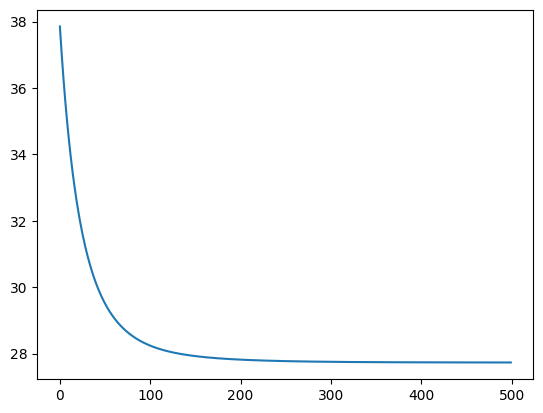

In [4]:
plt.plot(losses)

In [5]:
print("Original ratings:")
print(R)

Original ratings:
[[5. 3. 0. 1.]
 [4. 0. 0. 1.]
 [1. 1. 0. 5.]
 [1. 0. 0. 4.]
 [0. 1. 5. 4.]]


### Reconstructed Ratings

In [6]:
print("Reconstructed ratings:")
R_hat = avg_rating + user_bias[None, :] + item_bias[:, None]
print(np.round(R_hat, 2))

Reconstructed ratings:
[[3.39 2.39 2.76 2.4  3.14]
 [1.96 0.96 1.32 0.97 1.7 ]
 [5.23 4.23 4.59 4.24 4.98]
 [3.6  2.59 2.96 2.61 3.34]]


In [7]:
user_bias, item_bias

(array([ 0.66653365, -0.33668706,  0.02688787, -0.32327512,  0.41037416]),
 array([-0.04111797, -1.47561217,  1.79879217,  0.16192943]))

## SVD

See formula here:

https://github.com/recommenders-team/recommenders/blob/main/examples/02_model_collaborative_filtering/surprise_svd_deep_dive.ipynb

In [8]:
# Assume we have some ratings matrix R
R = np.array(
    [[5, 3, 0, 1], [4, 0, 0, 1], [1, 1, 0, 5], [1, 0, 0, 4], [0, 1, 5, 4]],
    dtype=np.float32,
)

# Initialize user and item embedding matrices
num_users, num_items = R.shape
embedding_dim = 10
U = np.random.normal(size=(num_users, embedding_dim))
V = np.random.normal(size=(num_items, embedding_dim))

# Initialize user and item bias vectors
user_bias = np.zeros(num_users)
item_bias = np.zeros(num_items)

# Initialize average rating.
avg_rating = R[R.nonzero()].mean()

# Define the learning rate and regularization strength
lr = 0.01
reg_strength = 1e-5
losses = []

mask = R > 0
# We take into considerating the known ratings only when calculating errors.
known_ratings = np.sum(mask)

# Define the loss function
def sse_loss(U, V, user_bias, item_bias, avg_rating, R):
    R_hat = U @ V.T + user_bias[:, None] + item_bias[None, :] + avg_rating
    R_hat *= mask

    # Squared sum error (SSE) of known ratings.
    loss = np.sum(np.square(R - R_hat))
    # Add regularization
    loss += reg_strength * (
        np.sum(U ** 2)
        + np.sum(V ** 2)
        + np.sum(user_bias ** 2)
        + np.sum(item_bias ** 2)
    )
    return loss


# Run the optimization
for t in range(500):
    for u, i in zip(*R.nonzero()):
        b_u = user_bias[u]
        b_i = item_bias[i]
        R_hat = U[u, :] @ V[i, :].T + b_u + b_i + avg_rating
        error = R[u, i] - R_hat

        # Compute gradients
        grad_U = error * V[i, :] - reg_strength * U[u, :]
        grad_V = error * U[u, :] - reg_strength * V[i, :]
        grad_user_bias = error - reg_strength * b_u
        grad_item_bias = error - reg_strength * b_i

        # Update parameters
        U[u, :] += lr * grad_U
        V[i, :] += lr * grad_V
        user_bias[u] += lr * grad_user_bias
        item_bias[i] += lr * grad_item_bias

    loss = sse_loss(U, V, user_bias, item_bias, avg_rating, R)
    if i % 100 == 0:
        print("Iteration", i, "Loss", loss)
    losses.append(loss)

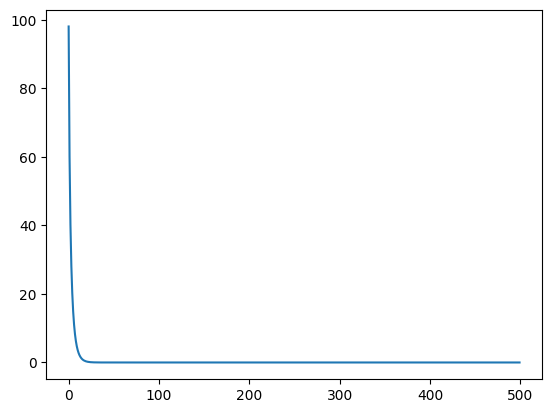

In [9]:
plt.plot(losses)

In [10]:
print("Original ratings:")
print(R)

Original ratings:
[[5. 3. 0. 1.]
 [4. 0. 0. 1.]
 [1. 1. 0. 5.]
 [1. 0. 0. 4.]
 [0. 1. 5. 4.]]


### Reconstructed Ratings

In [11]:
print("Reconstructed ratings:")
R_hat = U @ V.T + user_bias[:, None] + item_bias[None, :] + avg_rating
print(np.round(R_hat, 2))

Reconstructed ratings:
[[ 5.    3.    2.91  1.  ]
 [ 4.   -3.07 -3.69  1.  ]
 [ 1.    1.    4.48  5.  ]
 [ 1.   -0.36  1.09  4.  ]
 [ 1.18  1.    5.    4.  ]]


In [12]:
sse_loss(U, V, user_bias, item_bias, avg_rating, R)

0.0010407735870494564

### Output

In [13]:
# If the replace does not work, check if the data type for R matches R_hat, which is float.
# If the data type of the matrix to replace does not match, it will silently failed.
mask = R == 0
R[mask] = R_hat[mask]
np.maximum(np.round(R, 1), 0)

array([[5. , 3. , 2.9, 1. ],
       [4. , 0. , 0. , 1. ],
       [1. , 1. , 4.5, 5. ],
       [1. , 0. , 1.1, 4. ],
       [1.2, 1. , 5. , 4. ]], dtype=float32)

## Using Keras

The `tf.reduce_sum` function is used in the loss function to sum up all the individual squared differences between the actual ratings and the predicted ratings.

In the context of matrix factorization, the goal is to find the user and item embeddings that minimize the total (or sum of) squared differences between the actual and predicted ratings. This is known as the Mean Squared Error (MSE) loss, and it's a common choice for regression problems.

The `tf.reduce_sum` function is used instead of `tf.reduce_mean` because we're only considering non-zero entries in the ratings matrix (i.e., the user-item pairs where a rating is available). The number of such entries is not fixed (it depends on the sparsity of the ratings matrix), so it's simpler to sum up all the squared differences and let the optimizer find the minimum of this sum.

If you were to use `tf.reduce_mean`, you would need to divide by the number of non-zero entries, which would add an extra step to the computation. The optimizer would still be able to find the minimum of the mean loss, but the loss values reported during training would be smaller by a factor equal to the number of non-zero entries.

In [14]:
import tensorflow as tf

R = tf.constant(
    [[5, 3, 0, 1], [4, 0, 0, 1], [1, 1, 0, 5], [1, 0, 0, 4], [0, 1, 5, 4]],
    dtype=tf.float32,
)
n_user, n_item = R.shape
K = min(R.shape) - 2


U = tf.Variable(tf.random.normal([n_user, K], stddev=0.1))
V = tf.Variable(tf.random.normal([n_item, K], stddev=0.1))

N = n_user * n_item


avg_rating = tf.constant(
    tf.math.reduce_mean(R[tf.math.not_equal(R, 0)]), name="global_average"
)
b_u = tf.Variable(tf.zeros(n_user), name="user_bias")
b_i = tf.Variable(tf.zeros(n_item), name="item_bias")

T = 500  # Epochs
alpha = 0.01  # learning rate
beta = 1e-5

trainable_weights = [U, V, b_u, b_i]
optimizer = tf.keras.optimizers.SGD(learning_rate=alpha, weight_decay=beta)
losses = []

# Define the loss function
def mse_loss(U, V, b_u, b_i, R):
    R_hat = tf.matmul(U, V, transpose_b=True) + b_u[:, None] + b_i[None, :] + avg_rating

    # non_zero_mask = tf.math.not_equal(tf.reshape(R, [-1]), 0)
    # indices = tf.where(non_zero_mask)
    # loss = tf.keras.metrics.mean_squared_error(
    #     tf.gather(tf.reshape(R, [-1]), indices),
    #     tf.gather(tf.reshape(R_hat, [-1]), indices),
    # )
    # return loss
    # num_ratings = tf.reduce_sum(tf.cast(non_zero_mask, tf.float32))
    # loss = tf.reduce_sum(tf.square(R - R_hat) * tf.cast(non_zero_mask, tf.float32))
    # return tf.divide(loss, num_ratings)
    # We are not using the mean.
    # This changes the scale of the loss values and the gradients, but doesn't fundamentally change the optimization problem.
    non_zero_mask = tf.math.not_equal(R, 0)
    loss = tf.reduce_sum(tf.square(R - R_hat) * tf.cast(non_zero_mask, tf.float32))
    return loss


for t in range(T):
    with tf.GradientTape() as tape:
        # We rely on automatic differentiation to calculate the gradient loss.
        loss = mse_loss(U, V, b_u, b_i, R)
    grads = tape.gradient(loss, trainable_weights)
    optimizer.apply_gradients(zip(grads, trainable_weights))
    losses.append(tf.reduce_mean(loss).numpy())

    if t % 100 == 0:
        print(t, tf.reduce_mean(loss).numpy())

2024-01-30 03:51:57.592935: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


0 38.574196
100 0.31343275
200 0.01619082
300 0.0006182658
400 2.1748392e-05


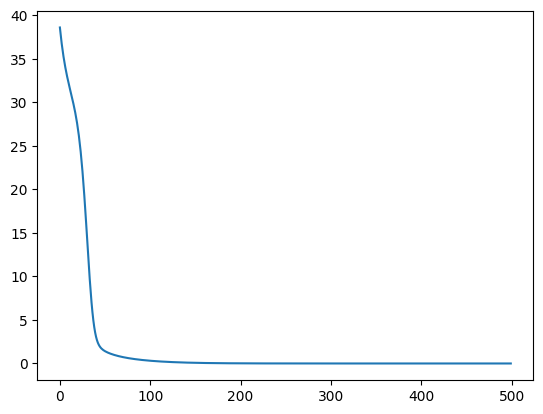

In [15]:
plt.plot(losses)

In [16]:
R_hat = (
    tf.matmul(U, V, transpose_b=True) + b_u[:, None] + b_i[None, :] + avg_rating
).numpy()
R = R.numpy()

In [17]:
R

array([[5., 3., 0., 1.],
       [4., 0., 0., 1.],
       [1., 1., 0., 5.],
       [1., 0., 0., 4.],
       [0., 1., 5., 4.]], dtype=float32)

### Reconstructed Ratings

In [18]:
np.round(R_hat, 2)

array([[5.  , 3.  , 4.85, 1.  ],
       [4.  , 2.29, 4.36, 1.  ],
       [1.  , 1.  , 5.13, 5.  ],
       [1.  , 0.69, 4.63, 4.  ],
       [1.6 , 1.  , 5.  , 4.  ]], dtype=float32)

In [19]:
mask = R == 0
R[mask] = R_hat[mask]
np.round(R, 1)

array([[5. , 3. , 4.8, 1. ],
       [4. , 2.3, 4.4, 1. ],
       [1. , 1. , 5.1, 5. ],
       [1. , 0.7, 4.6, 4. ],
       [1.6, 1. , 5. , 4. ]], dtype=float32)

### Output

In [20]:
# We still have issue with negative values, and some values goes beyond 5.
np.round(np.clip(R, 0, 5), 1)

array([[5. , 3. , 4.8, 1. ],
       [4. , 2.3, 4.4, 1. ],
       [1. , 1. , 5. , 5. ],
       [1. , 0.7, 4.6, 4. ],
       [1.6, 1. , 5. , 4. ]], dtype=float32)

## Keras, skipping ratings

In [21]:
import numpy as np
import tensorflow as tf

# Assume we have some ratings matrix R
R = np.array(
    [[5, 3, 0, 1], [4, 0, 0, 1], [1, 1, 0, 5], [1, 0, 0, 4], [0, 1, 5, 4]],
    dtype=np.float32,
)

# Get the number of users and items
num_users, num_items = R.shape

# Get the indices of non-zero entries
user_ids, item_ids = np.nonzero(R)

# Get the corresponding ratings
ratings = R[user_ids, item_ids]

# Define the embedding dimension
embedding_dim = 2

# Initialize user and item embedding matrices
U = tf.Variable(tf.random.normal((num_users, embedding_dim)))
V = tf.Variable(tf.random.normal((num_items, embedding_dim)))

# Initialize user and item bias vectors
user_bias = tf.Variable(tf.zeros(num_users))
item_bias = tf.Variable(tf.zeros(num_items))

# Initialize global bias
avg_rating = tf.constant(np.mean(ratings))

# Define the learning rate
lr = 0.01

# Define the number of epochs
epochs = 500

# Define the optimizer
optimizer = tf.optimizers.Adam(lr)
losses = []
# Run the optimization
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # Compute the dot product between the user and item embeddings
        prediction = tf.reduce_sum(
            tf.gather(U, user_ids) * tf.gather(V, item_ids), axis=1
        )

        # Add the biases to the prediction
        prediction += (
            avg_rating + tf.gather(user_bias, user_ids) + tf.gather(item_bias, item_ids)
        )

        # Compute the mean squared error loss
        loss = tf.reduce_mean((ratings - prediction) ** 2)

    # Compute the gradients
    grads = tape.gradient(loss, [U, V, user_bias, item_bias])

    # Apply the gradients
    optimizer.apply_gradients(zip(grads, [U, V, user_bias, item_bias]))
    if epoch % 100 == 0:
        print("Epoch", epoch, "Loss", loss.numpy())
    losses.append(loss.numpy())

Epoch 0 Loss 4.8182354
Epoch 100 Loss 0.38364327
Epoch 200 Loss 0.037215076
Epoch 300 Loss 0.00077601854
Epoch 400 Loss 1.9329402e-06


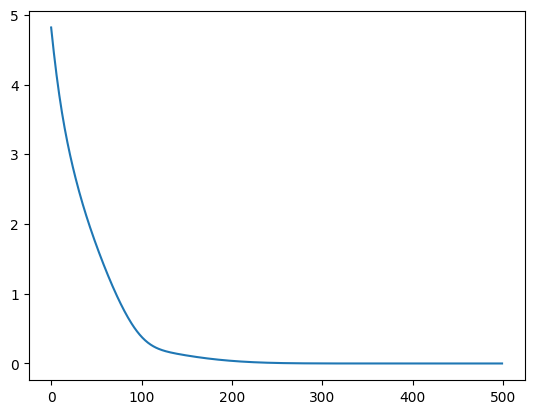

In [22]:
plt.plot(losses)

### Reconstructed Ratings

In [23]:
R_hat = (
    U.numpy() @ V.numpy().T
    + avg_rating.numpy()
    + user_bias.numpy()[:, None]
    + item_bias.numpy()[None, :]
)
np.round(R_hat, 2)

array([[5.  , 3.  , 9.05, 1.  ],
       [4.  , 4.74, 7.58, 1.  ],
       [1.  , 1.  , 2.06, 5.  ],
       [1.  , 2.71, 2.36, 4.  ],
       [2.84, 1.  , 5.  , 4.  ]], dtype=float32)

## SGD

In [24]:
import numpy as np

# Assume we have some ratings matrix R
R = np.array(
    [[5, 3, 0, 1], [4, 0, 0, 1], [1, 1, 0, 5], [1, 0, 0, 4], [0, 1, 5, 4]],
    dtype=np.float32,
)

# Initialize user and item embedding matrices
num_users, num_items = R.shape
embedding_dim = 2
U = np.random.normal(size=(num_users, embedding_dim))
V = np.random.normal(size=(num_items, embedding_dim))

# Initialize user and item bias vectors
user_bias = np.zeros(num_users)
item_bias = np.zeros(num_items)

# Initialize global bias
avg_rating = np.mean(R[R > 0])

# Define the learning rate
lr = 0.01

# Define the number of epochs
epochs = 500
losses = []
# Run the optimization
for epoch in range(epochs):
    for i in range(num_users):
        for j in range(num_items):
            if R[i, j] > 0:  # only consider non-zero entries
                error = R[i, j] - (
                    avg_rating + np.dot(U[i, :], V[j, :]) + user_bias[i] + item_bias[j]
                )
                U[i, :] += lr * error * V[j, :]
                V[j, :] += lr * error * U[i, :]
                user_bias[i] += lr * error
                item_bias[j] += lr * error

    mse_loss = np.sum(
        (R - (avg_rating + np.dot(U, V.T) + user_bias[:, None] + item_bias[None, :]))
        ** 2
    ) / np.sum(R > 0)
    if epoch % 100 == 0:
        print("Epoch", epoch, "MSE Loss", mse_loss)
    losses.append(mse_loss)

Epoch 0 MSE Loss 6.1185182462121555
Epoch 100 MSE Loss 3.1841804171769805
Epoch 200 MSE Loss 3.136495989963544
Epoch 300 MSE Loss 3.1315523532306746
Epoch 400 MSE Loss 3.130803120373311


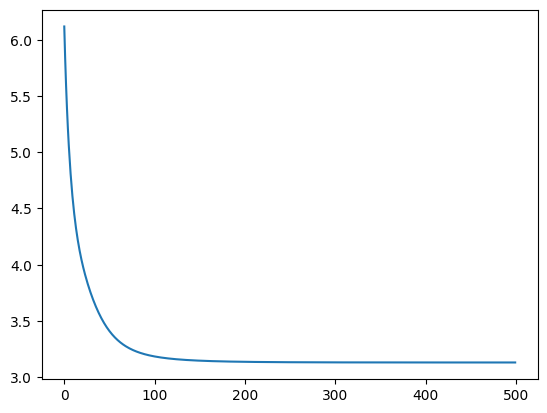

In [25]:
plt.plot(losses)

### Reconstructed Ratings

In [26]:
np.round(avg_rating + np.dot(U, V.T) + user_bias[:, None] + item_bias[None, :], 2)

array([[5.  , 3.  , 3.47, 1.  ],
       [4.  , 1.82, 3.27, 1.  ],
       [1.  , 1.  , 1.18, 5.  ],
       [1.  , 1.17, 0.4 , 4.  ],
       [3.42, 1.  , 5.  , 4.  ]])